# Задания №1 

### Вопрос:
Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене) 


In [41]:
import pandas as pd
import numpy as np
from IPython.display import display_html
from itertools import chain,cycle

import seaborn as sns
from matplotlib import pyplot as plt

from scipy.stats import chi2_contingency
from statsmodels.graphics.mosaicplot import mosaic

sns.set(rc={'figure.figsize':(10,7)})

In [3]:
assessments = pd.read_csv('assessments.csv')  
courses = pd.read_csv('courses.csv')  
student_assesment = pd.read_csv('studentAssessment.csv')  
student_registration = pd.read_csv('studentRegistration.csv')  


courses_reg = pd.merge(courses,student_registration,on=['code_module', 'code_presentation'])
grade = pd.merge(courses_reg, assessments,on= ['code_module', 'code_presentation'])
full_grade = pd.merge(grade, student_assesment,on=['id_assessment', 'id_student'])

## Студенты, кто сдавали экзамен

Посмотрим на студентов, кто в принципе хорошо сдал экзамен: score >= 40

In [4]:
#Сабсет тех, у кого оценка > 40
full_grade.query('assessment_type == "Exam" & score == score & score >= 40').id_student.nunique()

4097

У нас всего 4097 студентов, кто хорошо сдали экзамены.   
Но сдача одного экзамена в рамках одного семестра ≠ сдача курса   
Сдача курса = сдача одного или двух экзаменов в рамках двух семестров!

## Те, кто не сдавали экзамен

Давайте для начала разделим дата-сет на два:
- там где нет передсачников 
- там где есть пересдачники   
(на всякий)

In [5]:
#Дата-сет, кто не сдавал экзамены 
examini = full_grade[full_grade['assessment_type'] == "Exam"].id_student.unique().tolist()

no_ex = full_grade[~full_grade.id_student.isin(examini)]


In [6]:
#Список критерий
revalue = no_ex[no_ex['is_banked'] == 1].id_student.unique().tolist()

#Дата-сет без передсач
no_revalue = no_ex[~no_ex.id_student.isin(revalue)]

#Дата-сет с передсачами
peresdachniki = no_ex[no_ex.id_student.isin(revalue)]

### Все теперь давайте посчитаем наконец-то число студентов без экзамена и пересдач, кто сдали 1 курс успешно!

In [7]:
final_students = no_revalue.query('assessment_type != "Exam" & date_unregistration != date_unregistration & score == score') \
    .groupby('id_student', as_index = False) \
    .agg({'weight' : 'sum','code_module' : pd.Series.nunique, 
          'assessment_type' : 'count','code_presentation' : pd.Series.nunique}) \
    .query('weight == 100 & code_presentation == 2 & code_module == 2').id_student.tolist()

final = no_revalue[no_revalue.id_student.isin(final_students)]

final_num = final.query('score >= 40') \
     .groupby(['code_module', 'id_student','code_presentation'], as_index = False) \
     .agg({'assessment_type' : 'count'}) \
     .query('''(code_module == "GGG" & assessment_type >= 9) or \
    (code_module == "BBB" & assessment_type == 4 or assessment_type == 5 or assessment_type == 11) or \
    (code_module == "FFF" & assessment_type > 5)
     ''')

duplicates_num = final_num['id_student'].value_counts()
duplicates_num = duplicates_num[duplicates_num == 2]
duplicates_num = duplicates_num.index.to_list()
final_no_test_students= final_num[final_num.id_student.isin(duplicates_num)].sort_values(by = 'id_student')
final_no_test_students

,code_module,id_student,code_presentation,assessment_type
1,BBB,391937,2014J,5
32,GGG,391937,2014B,9
4,BBB,497074,2014J,5
35,GGG,497074,2013J,9
38,GGG,557085,2013J,9
29,FFF,557085,2014J,12
39,GGG,571334,2013J,9
7,BBB,571334,2014J,5
8,BBB,574512,2014J,4
40,GGG,574512,2013J,9


Считаем количество студентов, кто успешно сдал курс по предметам без экзамена

In [8]:
final_no_test_students.id_student.nunique()

18

### Закончили! 

* Студенты, кто успешно сдал курс (в рамках сдачи 2х экзаменов): 295
* Студенты, кто успешно сдал курс (в рамках сдачи тестов на предмете): 18

##### Общее количество: 313

# Задания №2

In [9]:
#Список критерий
examini = full_grade[full_grade['assessment_type'] == "Exam"].id_student.unique().tolist()

#Дата-сет с экзаменами
examin_data = full_grade[full_grade.id_student.isin(examini)]

In [24]:
#Те, кто отказался проходить курс и удаляем его 
dropped_st = int(examin_data.query('date_unregistration == date_unregistration & score == score & assessment_type == "Exam"')['id_student'])

#Удаление
examin_data_new = examin_data[~examin_data.id_student.isin([dropped_st])]

In [25]:
#Те, у кого была отмена регистрации на тест, но успешно сданный экзамен
check_drop = examin_data_new.query('date_unregistration == date_unregistration').id_student.unique().tolist()
check_drop_data = examin_data_new[examin_data_new.id_student.isin(check_drop)]

check_drop_data['is_ex'] = np.where(check_drop_data['assessment_type'] == "Exam", 1, 0).tolist()

check_drop_data.groupby(['id_student', 'code_module', 'code_presentation'], as_index = False) \
    .agg({'assessment_type' : 'count',
         'is_ex' : 'sum'})

C:\Users\Vitaly\AppData\Local\Temp/ipykernel_24084/451569370.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_drop_data['is_ex'] = np.where(check_drop_data['assessment_type'] == "Exam", 1, 0).tolist()


,id_student,code_module,code_presentation,assessment_type,is_ex
0,29411,CCC,2014J,2,0
1,29411,DDD,2013J,7,1
2,40419,DDD,2013B,2,0
3,40419,DDD,2013J,7,1
4,45664,CCC,2014B,3,0
...,...,...,...,...,...
528,2646737,DDD,2014J,7,1
529,2668106,CCC,2014J,9,1
530,2668106,DDD,2014B,3,0
531,2668945,DDD,2013J,3,0


In [27]:
#Подсчет общего кол-во сдач экзамена по каждому предмету | семестру
number_split = examin_data_new.query('assessment_type == "Exam"') \
    .groupby(['code_module', 'code_presentation'])['assessment_type'].value_counts().to_frame() \
    .rename({'assessment_type': 'num'}, axis='columns').reset_index() 

success_split = examin_data_new.query('assessment_type == "Exam" & score >= 40') \
    .groupby(['code_module', 'code_presentation'])['assessment_type'].value_counts().to_frame() \
    .rename({'assessment_type': 'num'}, axis='columns').reset_index() \
    .rename({'num': 'success'}, axis='columns')

gr_zavershaemost_split = number_split.merge(success_split, on = ['code_module', 'code_presentation', 'assessment_type'])

#Критерий завершимости
gr_zavershaemost_split['zavershaemost'] = round(gr_zavershaemost_split.success / gr_zavershaemost_split.num,2)
gr_zavershaemost_split

,code_module,code_presentation,assessment_type,num,success,zavershaemost
0,CCC,2014B,Exam,747,664,0.89
1,CCC,2014J,Exam,1168,1019,0.87
2,DDD,2013B,Exam,602,504,0.84
3,DDD,2013J,Exam,967,878,0.91
4,DDD,2014B,Exam,524,485,0.93
5,DDD,2014J,Exam,950,842,0.89


#### Визуализируем

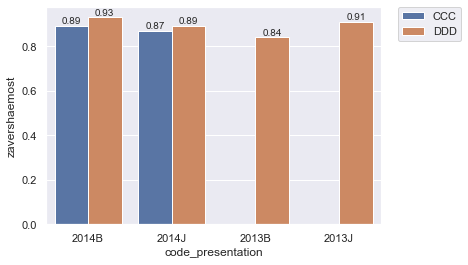

In [28]:
#Рисуем график
graph_module_pres = sns.barplot(x="code_presentation", y="zavershaemost", 
            data=gr_zavershaemost_split,hue="code_module")

#Отодвигаем легенду
graph_module_pres.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

#Подписываем цифры для каждого столбца
for container in graph_module_pres.containers:
    graph_module_pres.bar_label(container)

1. Среди студентов, кто сдавал экзамены:
    - никто их не пересдавал
    - все пришли на экзамен, кроме одного (он дропнулся)
    
    
2. Экзамены несложные, поскольку завершаемость достаточно высокая 

# Задания №3

#### Условие: сдача – это последнее успешное прохождение экзамена студентом. 

В нашем случае, date_submitted будет самой информотивной метрикой для определения среднего срока сдачи экзамена 

In [29]:
examin_data_new.query('score >= 40 & assessment_type == "Exam"') \
    [['code_module', 'code_presentation','id_student', 'module_presentation_length',
               'date', 'date_submitted']].groupby(['code_module', 'code_presentation']) \
                .agg({'module_presentation_length' : 'value_counts', 'date': 'value_counts','date_submitted': 'value_counts'})

module_presentation_length   date  \
code_module code_presentation                                          
CCC         2014B             241                       664.0    NaN   
            2014J             269                      1019.0    NaN   
DDD         2013B             240                       504.0  504.0   
            2013J             261                       878.0  878.0   
            2014B             241                       485.0  485.0   
            2014J             262                       842.0    NaN   
CCC         2014B             230                         NaN    NaN   
                              234                         NaN    NaN   
                              236                         NaN    NaN   
                              237                         NaN    NaN   
                              238                         NaN    NaN   
                              242                         NaN    NaN   
                              266                         NaN    NaN   
            2014J             244                         NaN    NaN   
                              245                         NaN    NaN   
                              243                         NaN    NaN   
                              248                         NaN    NaN   
                              250                         NaN    NaN   
                              251                         NaN    NaN   
                              252                         NaN    NaN   
                              259                         NaN    NaN   
                              249                         NaN    NaN   
                              285                         NaN    NaN   
DDD         2013B             230                         NaN    NaN   
                              229                         NaN    NaN   
                              231                         NaN    NaN   
                              233                         NaN    NaN   
                              241                         NaN    NaN   
            2013J             237                         NaN    NaN   
                              242                         NaN    NaN   
                              241                         NaN    NaN   
                              243                         NaN    NaN   
                              245                         NaN    NaN   
                              244                         NaN    NaN   
                              248                         NaN    NaN   
                              250                         NaN    NaN   
                              255                         NaN    NaN   
            2014B             234                         NaN    NaN   
                              236                         NaN    NaN   
                              237                         NaN    NaN   
                              238                         NaN    NaN   
                              242                         NaN    NaN   
                              251                         NaN    NaN   
            2014J             243                         NaN    NaN   
                              242                         NaN    NaN   
                              244                         NaN    NaN   
                              245                         NaN    NaN   
                              249                         NaN    NaN   
                              248                         NaN    NaN   
                              250                         NaN    NaN   
                              256                         NaN    NaN   
                              279                         NaN    NaN   

                                   date_submitted  
code_module code_presentation                      
CCC         2014B             241         

In [30]:
examin_data_new.query('score >= 40 & assessment_type == "Exam"') \
    .groupby('code_module', as_index = False).agg({'date_submitted' : 'mean'}).round(2)

,code_module,date_submitted
0,CCC,239.35
1,DDD,237.98


* Для предмета CCC студенты в среднем сдавали экзамен через 239 дней с начала семестра
* Для предмета DDD студенты в среднем сдавали экзамен через 238 дней с начала семестра

# Задания №4

### Топ 3 предмета по кол-во регистрации 

In [31]:
full_grade.groupby(['code_module'],as_index = False) \
    ['id_student'].nunique().sort_values('id_student', ascending = False).head(3)

,code_module,id_student
5,FFF,6058
1,BBB,5960
3,DDD,4699


### Топ 3 семестра по кол-во регистрации 

In [33]:
full_grade.groupby(['code_presentation'],as_index = False) \
    ['id_student'].nunique().sort_values('id_student', ascending = False).head(3)

,code_presentation,id_student
3,2014J,8613
1,2013J,7098
2,2014B,5748


## Количество пересдачников

In [34]:
full_grade.query('is_banked == 1 & date_registration == date_registration & date_unregistration != date_unregistration') \
    .groupby(['code_module', 'code_presentation'],as_index = False) \
    ['id_student'].nunique().id_student.sum()

383

## Топ 3 предмета с наибольшим оттоком

In [39]:
#Кол-во зарегистрированных студентов для каждого предмета
registrated_module = full_grade.groupby(['code_module'],as_index = False) \
    ['id_student'].nunique().rename(columns={'id_student': 'num_registration'})

#Кол-во пересдачников для каждого предмета
peresdachi_module = full_grade.query('is_banked == 1 & date_registration == date_registration & date_unregistration != date_unregistration') \
    .groupby(['code_module'],as_index = False) \
    ['id_student'].nunique().rename(columns={'id_student': 'num_peresdachi'})

#Кол-во отменивших регистрацию для каждого предмета
otmena_registration_module = full_grade.query('date_unregistration == date_unregistration & is_banked == 0') \
    .groupby(['code_module'],as_index = False) \
    ['id_student'].nunique().rename(columns={'id_student': 'num_otmena'})

#Соединяем 3 дата-сета
merged_1_module = registrated_module.merge(peresdachi_module, on = ['code_module'], how="left" ).fillna(0)
ottok_module = merged_1_module.merge(otmena_registration_module, on = ['code_module'], how="left")

#Создаем общую колонку – дропнутые студенты: кол-во пересдачников + кол-во отменивших регистрацию для каждого предмета 
ottok_module['no_reg'] = ottok_module['num_peresdachi'] + ottok_module['num_otmena']

#Считаем формулу оттока
ottok_module['ottok_percentage'] = round(ottok_module['no_reg'] / ottok_module['num_registration'],2)

#Сортируем данные по оттоку
ottok_module.sort_values(by = 'ottok_percentage', ascending = False).head(3)

,code_module,num_registration,num_peresdachi,num_otmena,no_reg,ottok_percentage
2,CCC,3318,23,1017,1040,0.31
3,DDD,4699,126,1059,1185,0.25
5,FFF,6058,123,1095,1218,0.20


## Ответ на вопрос 

Топ 3 предмета по кол-во регистрации FFF, BBB, DDD

Топ 3 семестра по кол-во регистрации 2014j, 2013j, 2014b

Топ 3 предмета по оттоку CCC, DDD, FFF

# Задания №5

In [42]:
#Функция для того, чтобы принтить два результата на одной странице
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [43]:
def cohort_analysis(data_set):
    avg_srok = data_set.query('score >= 40 & assessment_type == "Exam"') \
    .groupby(['code_module', 'code_presentation'], as_index = False) \
    .agg({'date_submitted' : 'mean'}).round(2)
    
    number_split = data_set.query('assessment_type == "Exam" & score == score') \
    .groupby(['code_module', 'code_presentation'])['assessment_type'].value_counts().to_frame() \
    .rename({'assessment_type': 'num'}, axis='columns').reset_index() 
    
    success_split = data_set.query('assessment_type == "Exam" & score >= 40 & score == score') \
    .groupby(['code_module', 'code_presentation'])['assessment_type'].value_counts().to_frame() \
    .rename({'assessment_type': 'num'}, axis='columns').reset_index() \
    .rename({'num': 'success'}, axis='columns')
    
    gr_zavershaemost_split = number_split.merge(success_split, on = ['code_module', 'code_presentation', 'assessment_type'])
    gr_zavershaemost_split['zavershaemost'] = round(gr_zavershaemost_split.success / gr_zavershaemost_split.num,2)
    gr_zavershaemost_split.drop(['assessment_type', 'num', 'success'], axis=1, inplace=True)
    cohort_data = avg_srok.merge(gr_zavershaemost_split, on = ['code_module', 'code_presentation'])

    srok_cohort = cohort_data.pivot_table(index = 'code_module', 
                                     columns = 'code_presentation', 
                                     values = 'date_submitted')

    zavershaemost_cohort = cohort_data.pivot_table(index = 'code_module', 
                                     columns = 'code_presentation', 
                                     values = 'zavershaemost')
    fig = plt.figure()  
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    graph_srok = sns.heatmap(srok_cohort, annot = True, fmt = '', ax=ax1)
    graph_zavershaemost = sns.heatmap(zavershaemost_cohort, annot = True, fmt = '')
    
    print(display_side_by_side(srok_cohort, zavershaemost_cohort, titles=['Средний срок','Завершаемость']))

code_presentation,2013B,2013J,2014B,2014J
code_module,,,,
CCC,NaN,NaN,231.58,244.4
DDD,230.16,239.51,234.94,242.8
code_presentation,2013B,2013J,2014B,2014J
code_module,,,,
CCC,NaN,NaN,0.89,0.87
DDD,0.84,0.91,0.93,0.89


None


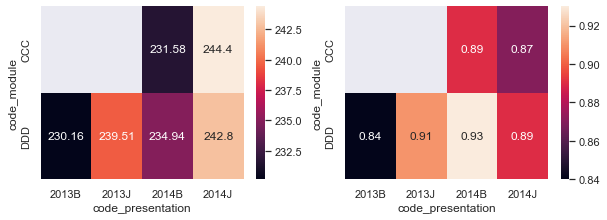

In [44]:
# Ответ
cohort_analysis(examin_data_new)

# Задания №6

In [48]:
# Считаем R – среднее время сдачи одного экзамена
recency = examin_data_new.query('score >= 40 & assessment_type == "Exam"') \
    .groupby(['code_module', 'code_presentation'], as_index = False) \
    .agg({'date_submitted' : 'mean'}).round(2)


# Считаем F – завершаемость курсов
number_split = examin_data_new.query('assessment_type == "Exam" & score == score') \
    .groupby(['code_module', 'code_presentation'])['assessment_type'].value_counts().to_frame() \
    .rename({'assessment_type': 'num'}, axis='columns').reset_index() 

success_split = examin_data_new.query('assessment_type == "Exam" & score >= 40 & score == score') \
    .groupby(['code_module', 'code_presentation'])['assessment_type'].value_counts().to_frame() \
    .rename({'assessment_type': 'num'}, axis='columns').reset_index() \
    .rename({'num': 'success'}, axis='columns')

frequency = number_split.merge(success_split, on = ['code_module', 'code_presentation', 'assessment_type'])
frequency['zavershaemost'] = round(frequency.success / frequency.num,2)
frequency.drop(['assessment_type', 'num', 'success'], axis=1, inplace=True)


# Считаем M – среднее количество баллов, получаемое за экзамен
monetary = examin_data_new.query('score >= 40 & assessment_type == "Exam"') \
    .groupby(['code_module', 'code_presentation'], as_index = False) \
    .agg({'score' : 'mean'}).round(2)